In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import math
import os

In [ ]:
# Calulate COM of an image
def imageCOM(image):
  y_indices, x_indices = np.indices(image.shape)
  total_intensity = image.sum()
  x_weighted_sum = (x_indices * image).sum()
  y_weighted_sum = (y_indices * image).sum()
  com_x = x_weighted_sum / total_intensity
  com_y = y_weighted_sum / total_intensity
  return int(round(com_x)), int(round(com_y))

In [ ]:
# Reize image with repect to aspect ratio
def resize_with_aspect_ratio(image, size):
    new_width, new_height = size
    h, w = image.shape[:2]

    f1, f2 = new_height / h, new_width / w
    f = f1 if f1 < f2 else f2
    new_h, new_w = math.floor(h * f), math.floor(w * f)

    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    new_image = np.zeros((new_height, new_width), dtype=np.uint8)

    x_offset = (new_width - new_w) // 2
    y_offset = (new_height - new_h) // 2

    new_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return new_image

In [ ]:
def convertImageToScoreMap(image_file, size=(1280 // 4, 720 // 4)):
  desired_sum = size[0] * size[1]
  base_image = 255 - np.array(Image.open(image_file).convert('L'))
  base_image = resize_with_aspect_ratio(base_image, size)
  base_image = cv2.GaussianBlur(base_image, (95, 95), 0,  borderType=cv2.BORDER_CONSTANT)

  normalized_image = base_image / 255.0
  current_sum = np.sum(normalized_image)
  scale_factor = desired_sum / current_sum
  scaled_image = normalized_image * scale_factor
  x, y = imageCOM(scaled_image)

  miss_penalty = -desired_sum / np.sum(scaled_image == 0)
  score_map = scaled_image
  score_map[score_map == 0] = miss_penalty

  return score_map, (x, y)


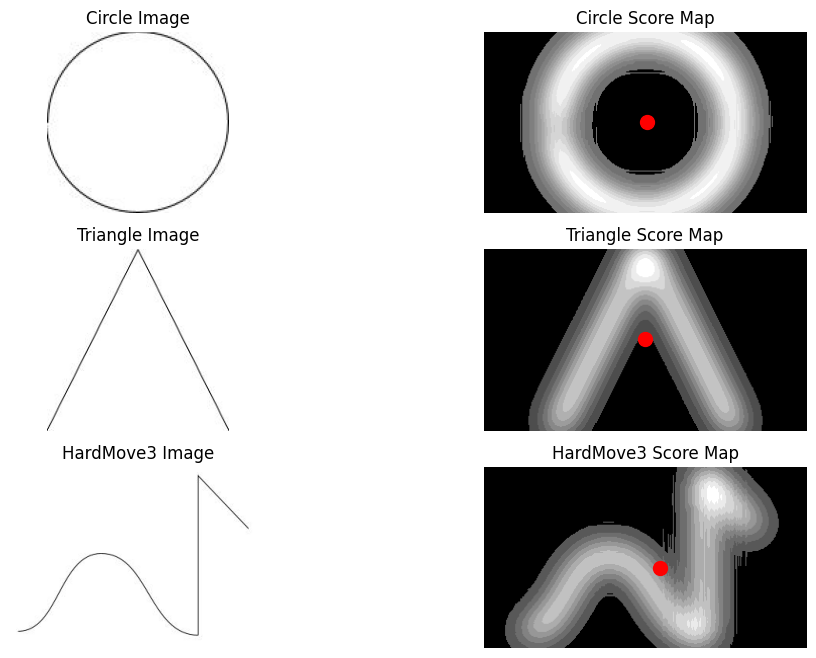

In [ ]:
# General process for creating a score map
image_dir = "/content/drive/MyDrive/CS131FinalProject"
file_names = ["Circle.jpg", "Triangle.jpg", "HardMove3.jpg"]

fig, axs = plt.subplots(len(file_names), 2, figsize=(12, 8))

for i, file in enumerate(file_names):
  path = os.path.join(image_dir, file)
  image = np.array(Image.open(path))
  score_map, com = convertImageToScoreMap(path)
  axs[i][0].imshow(image)
  axs[i][0].set_title(f"{file[:-4]} Image")
  axs[i][0].axis("off")
  axs[i][1].imshow(score_map, cmap='gray')
  axs[i][1].plot(com[0], com[1], 'o', ms=10, c="red")
  axs[i][1].set_title(f"{file[:-4]} Score Map")
  axs[i][1].axis("off")

plt.show()

In [ ]:
def generate_augmented_sparse_shapes(image_file,
                                     new_image_size,
                                     width_scale,
                                     hieght_scale,
                                     shift,
                                     point_count=30,
                                     thickness_tolerance_e=55):
  # Rescale it
  base_image = 255 - np.array(Image.open(image_file).convert('L'))
  h, w = base_image.shape[:2]
  new_w, new_h = int(round(w * width_scale)), int(round(h * hieght_scale))
  resized_image = cv2.resize(base_image, (new_w, new_h), interpolation=cv2.INTER_AREA)
  assert new_w < new_image_size[0] - shift[0] and new_h < new_image_size[1] - shift[1]

  # Shift it
  shifted_image = np.zeros(new_image_size)
  shifted_image[shift[1]:shift[1]+new_h, shift[0]:shift[0]+new_w] = resized_image

  # Make thing thickness = 1
  shifted_image[shifted_image < shifted_image.max() - thickness_tolerance_e] = 0
  shifted_image[shifted_image != 0] = 255

  # Make it sparse
  print("GEN INFO:", image_file, new_image_size, width_scale, hieght_scale, shift, np.sum(shifted_image != 0))
  p = point_count / np.sum(shifted_image != 0)
  if not 0 < p <= 1: p = 1
  shifted_image[np.random.rand(shifted_image.shape[0], shifted_image.shape[1]) >= p] = 0
  return shifted_image

In [ ]:
# Shift image onto score map
def translate_image_to_score_map(image, score_map_size, score_map_com):
  true_indices = np.where(image)
  min_row_index = np.min(true_indices[0])
  max_row_index = np.max(true_indices[0])
  min_col_index = np.min(true_indices[1])
  max_col_index = np.max(true_indices[1])
  cropped_image = image[min_row_index:max_row_index + 1, min_col_index:max_col_index + 1]

  resized_image = resize_with_aspect_ratio(cropped_image, (score_map_size[1], score_map_size[0]))
  resized_image[resized_image != 0] = 1
  xcom, ycom = imageCOM(resized_image)
  shift_x, shift_y = score_map_com[0] - xcom, score_map_com[1] - ycom

  translated_image = np.zeros(score_map_size)

  base_start_x = max(0, shift_x)
  base_end_x = min(resized_image.shape[1], shift_x + translated_image.shape[1])
  base_start_y = max(0, shift_y)
  base_end_y = min(resized_image.shape[0], shift_y + translated_image.shape[0])

  overlay_start_x = max(0, -shift_x)
  overlay_end_x = overlay_start_x + (base_end_x - base_start_x)
  overlay_start_y = max(0, -shift_y)
  overlay_end_y = overlay_start_y + (base_end_y - base_start_y)

  translated_image[base_start_y:base_end_y, base_start_x:base_end_x] = \
            resized_image[overlay_start_y:overlay_end_y, overlay_start_x:overlay_end_x]

  return translated_image


GEN INFO: /content/drive/MyDrive/CS131FinalProject/Circle.jpg (180, 320) 0.7 0.5 (10, 50) 147
28.0


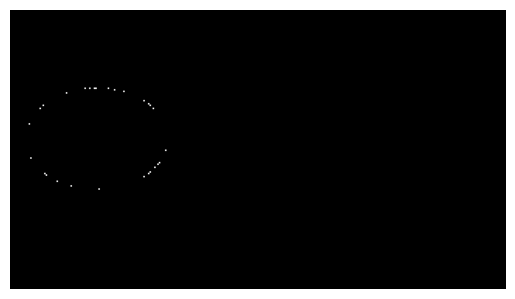

In [ ]:
aug_image = generate_augmented_sparse_shapes("/content/drive/MyDrive/CS131FinalProject/Circle.jpg",
                                     (180, 320),
                                     0.7,
                                     0.5,
                                     (10, 50),
                                     point_count=30,
                                     thickness_tolerance_e=55)

print(np.sum(aug_image) / 255)
plt.imshow(aug_image, cmap="gray")
plt.axis("off")
plt.show()

497.31295019908606


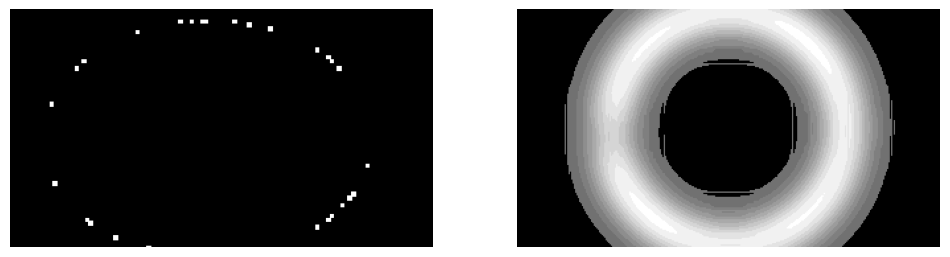

In [ ]:
triangle_file = "/content/drive/MyDrive/CS131FinalProject/Circle.jpg"
score_map, com = convertImageToScoreMap(triangle_file, size=(1280 // 4, 720 // 4))
translated_aug_image = translate_image_to_score_map(aug_image, score_map.shape, com)
# print(score_map[translated_aug_image != 0].flatten())
# print(translated_aug_image[translated_aug_image != 0].flatten())
print(np.sum(translated_aug_image * score_map))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(translated_aug_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(score_map, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
# Find threshold
params = [[(180, 320), 0.5, 0.5, (0, 0)], [(180, 320), 0.7, 0.5, (0, 0)], [(180, 320), 0.7, 0.5, (0, 0)]]
scores = [[], []]
for i, file in enumerate(file_names[:-1]):
  file = os.path.join("/content/drive/MyDrive/CS131FinalProject", file)
  for p in params:
    p = [file] + p
    score_map, com = convertImageToScoreMap(file)
    input = translate_image_to_score_map(generate_augmented_sparse_shapes(*p), score_map.shape, com)
    scores[i] += [np.sum(score_map * input)]

print(scores)
mins = []
for s in scores:
  mins.append(min(s))
print(mins)
print(min(mins))


GEN INFO: /content/drive/MyDrive/CS131FinalProject/Circle.jpg (180, 320) 0.5 0.5 (0, 0) 175
GEN INFO: /content/drive/MyDrive/CS131FinalProject/Circle.jpg (180, 320) 0.7 0.5 (0, 0) 147
GEN INFO: /content/drive/MyDrive/CS131FinalProject/Circle.jpg (180, 320) 0.7 0.5 (0, 0) 147
GEN INFO: /content/drive/MyDrive/CS131FinalProject/Triangle.jpg (180, 320) 0.5 0.5 (0, 0) 192
GEN INFO: /content/drive/MyDrive/CS131FinalProject/Triangle.jpg (180, 320) 0.7 0.5 (0, 0) 189
GEN INFO: /content/drive/MyDrive/CS131FinalProject/Triangle.jpg (180, 320) 0.7 0.5 (0, 0) 189
[[239.6298006012362, -102.26271628187789, 375.76564598928513], [735.6892432751079, 504.907193107169, 401.4021786831293]]
[-102.26271628187789, 401.4021786831293]
-102.26271628187789


In [ ]:
# Tolerance = 400